In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Combining Train and Test Data for Consistent Cleaning

In [94]:
TRAIN_FILE = "Groceries data train.csv"
TEST_FILE  = "Groceries data test.csv"
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)

# Label and combine training and test datasets
train_df["dataset"] = "train"
test_df ["dataset"] = "test"
df = pd.concat([train_df, test_df], ignore_index=True)

# Check for missing values
print(f"train rows: {len(train_df):,} test rows: {len(test_df):,}")
print(f"Total rows after merging: {len(df):,}")
df.head()

train rows: 27,000 test rows: 11,765
Total rows after merging: 38,765


,Member_number,Date,itemDescription,year,month,day,day_of_week,dataset
0,3021,30/01/2015,frankfurter,2015,1,30,4,train
1,1292,24/10/2015,pork,2015,10,24,5,train
2,4206,4/04/2014,root vegetables,2014,4,4,4,train
3,4369,25/08/2015,onions,2015,8,25,1,train
4,1522,1/07/2014,waffles,2014,7,1,1,train


The training and test datasets are combined to ensure global consistency during preprocessing. Merging both datasets allows identical cleaning and transformation operations to be applied uniformly across all records. This approach helps avoid discrepancies caused by processing the two datasets separately. Once preprocessing is complete, the merged dataset can be separated back into training and test sets for their respective downstream tasks.

### 2. Data Integrity and Missing Value Analysis

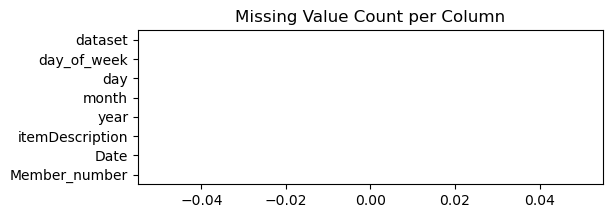

In [95]:
# Visualize the number of missing values in each column
missing_counts = df.isna().sum()

plt.figure(figsize=(6,2))
missing_counts.plot(kind='barh')
plt.title("Missing Value Count per Column")
plt.show()

In [96]:
# Count the number of fully duplicated rows before removal
before_duplicates = df.duplicated().sum()
print(f"Duplicate rows before removal: {before_duplicates}")

# Count the number of duplicated rows after removal to verify cleanup
df = df.drop_duplicates()
after_duplicates = df.duplicated().sum()
print(f"Duplicate rows after removal: {after_duplicates}")

Duplicate rows before removal: 437
Duplicate rows after removal: 0


In [97]:
# Display the number of unique values in each column
print("Number of unique values per column:\n", df.nunique())

Number of unique values per column:
 Member_number      3898
Date                728
itemDescription     167
year                  2
month                12
day                  31
day_of_week           7
dataset               2
dtype: int64


### 3. 粒度验证（篮子尺寸分布）

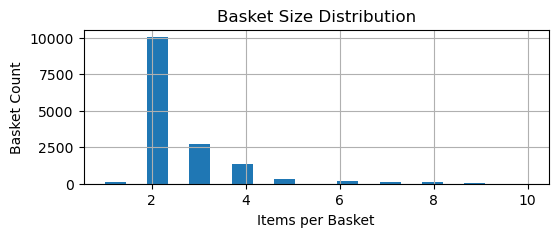

count    14963.000000
mean         2.561518
std          1.083535
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: basket_items, dtype: float64


In [98]:
DATE_COL = "Date"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce', dayfirst=True)

basket_size = (
    df.groupby(['Member_number', DATE_COL])
      .size()
      .rename("basket_items")
)

plt.figure(figsize=(6,2))
basket_size.hist(bins=20)
plt.title("Basket Size Distribution")
plt.xlabel("Items per Basket")
plt.ylabel("Basket Count")
plt.show()

print(basket_size.describe())

- **粒度（Granularity）**指的是数据的详细程度。
  - 这份数据同一次交易会根据不同商品类型分为多条数据。比如一个客户在某一时间购买了“牛奶”、“水果”、“蔬菜”，那么存在数据里是3行数据，但它们的MemberNumber和Date是一样的。
  - 进行粒度分析指的是：根据“会员号 + 日期”来识别一笔交易（即一个购物篮），统计这个“篮子”中总共购买了多少个商品条目，通过这种方式来进行 “关联规则分析”，就是Part1的主要目的

- 从上图可以观察到，每个客户每次购物最多购买两种类型的商品（basket_size = 2 直接占比75%），说明每次客户购买商品只买2-3件商品
- 最大篮子只有 11 件商品，没有离谱的大单子（比如 100+），数据质量良好。

### 4. 商品频次分布（头部 & 尾部）

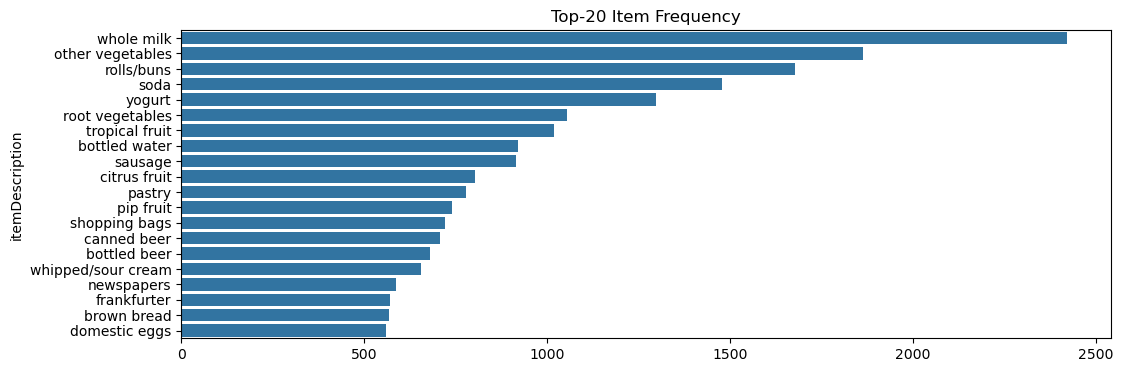

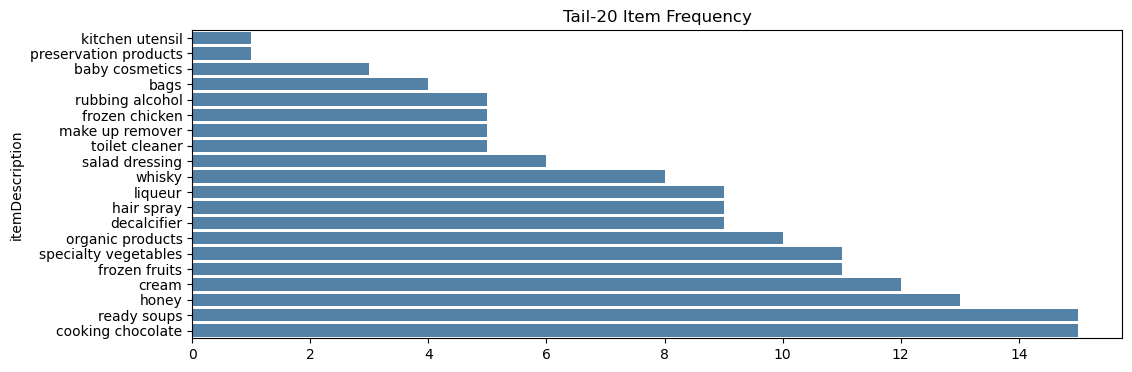

In [99]:
item_cnt = df['itemDescription'].value_counts()

# 头部 20
plt.figure(figsize=(12,4))
sns.barplot(x=item_cnt.head(20).values, y=item_cnt.head(20).index)
plt.title("Top-20 Item Frequency")
plt.show()

# 尾部 20
plt.figure(figsize=(12,4))
sns.barplot(x=item_cnt.sort_values().head(20).values,
            y=item_cnt.sort_values().head(20).index,
            color="steelblue")
plt.title("Tail-20 Item Frequency")
plt.show()

In [100]:
# ---------- 频次阈值（双侧过滤） ----------
MIN_ITEM_FREQ = 10

- 观察购买商品数量前20的商品，其中最多的明显是 whole milk，用于辅助验证结果
- 观察购买商品数量后20的商品，目的是为了进行“数据裁剪”，排除掉很小一部分不那么重要的数据，保证结果的稳定
  - 此处保守设置为MIN_ITEM_FREQ = 50，也就是排除掉值为50以下数据（暂定）
  - 补充：MIN_ITEM_FREQ设置过150，100，50，但直接筛选掉过多的结果，因此设置成较小的值 MIN_ITEM_FREQ=10，仅作展示保证技术深度

### 5. 时序分布（月趋势 & 周几柱状)

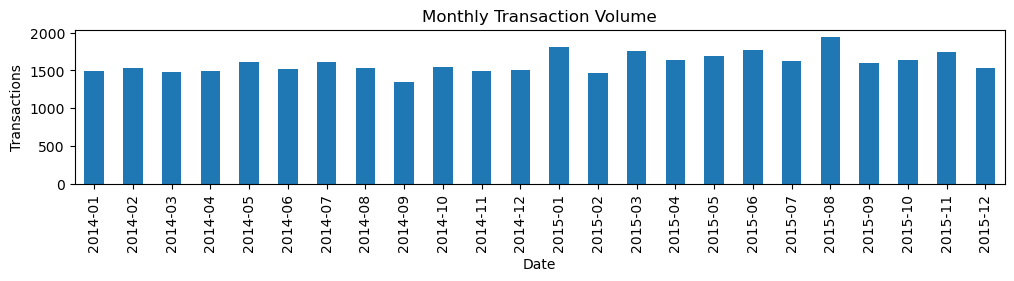

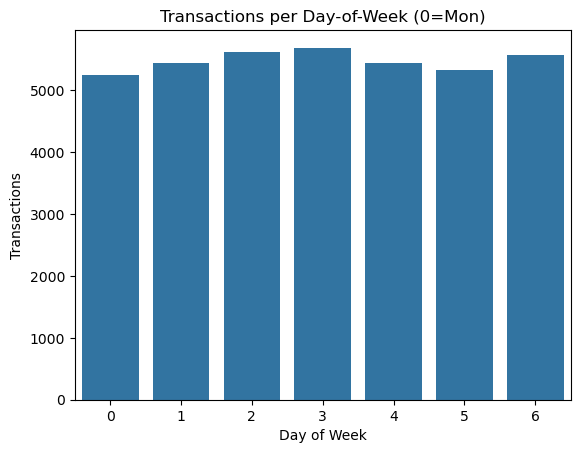

In [101]:
# 月度交易量
monthly_cnt = df.groupby(df[DATE_COL].dt.to_period('M')).size()
monthly_cnt.plot(kind='bar', figsize=(12,2), title="Monthly Transaction Volume")
plt.ylabel("Transactions"); plt.show()

# 周几分布
dow_cnt = df['day_of_week'].value_counts().sort_index()
sns.barplot(x=dow_cnt.index, y=dow_cnt.values)
plt.title("Transactions per Day-of-Week (0=Mon)")
plt.xlabel("Day of Week"); plt.ylabel("Transactions")
plt.show()

这一步的目的还是为了观察数据的合理性，观察结果可得：
图1：
  - 整体分布较均衡，大部分月份交易量在 1200–1500 左右。
  - 2015年1月和8月有明显高峰。
  - 2014年9月偏低，可能是异常波动、数据缺失或真实淡季。

图2：
  - 周三（3）是交易最高的日子，其次是周二、周四。
  - 周一交易最少，但差距不大。
  - 周末（5=周六, 6=周日）并未明显更高，说明非典型的「周末高峰」。

结论：
  - 顾客工作日更活跃：活跃集中在周中（Tue–Thu），说明用户可能为上班族，在工作日顺带购物
  - 没有典型“周末购物高峰”：表明商店或平台定位并非以休闲购物为主（如超市或便利店）
  - 周三可尝试营销推送：在周三推送折扣、优惠券等，可能有更高转化
  - 门店人力安排建议：排班可稍偏重周中，周末可减少人手

这一步对之后的代码无影响，主要用于辅助 数据健康检查、关联规则结果解释等观察和结论解释使用

### 6. 用户购买多样性

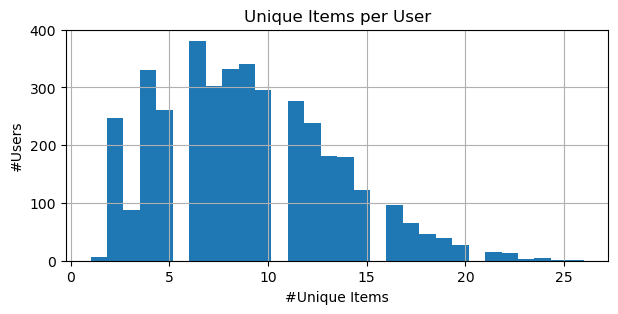

count    3898.000000
mean        8.918933
std         4.403278
min         1.000000
25%         6.000000
50%         8.500000
75%        12.000000
max        26.000000
Name: itemDescription, dtype: float64


In [102]:
# Cell 6 ─ 用户购买多样性
user_div = df.groupby('Member_number')['itemDescription'].nunique()

plt.figure(figsize=(7,3))
user_div.hist(bins=30)
plt.title("Unique Items per User")
plt.xlabel("#Unique Items")
plt.ylabel("#Users")
plt.show()

print(user_div.describe())

这一步的作用是：观察每个客户购买了多少种类型的商品，如果某个客户只买了一种类型的商品，对“关联性分析”是没有帮助的，需要主动移除
观察结果可得：平均每个客户买过8.9种不同类型的商品，其中存在只买了一个商品的客户，这种数据需要剔除

### 7. 数据清洗

In [103]:
# 记录原始行数
total_start = len(df)
print(f"原始数据共 {total_start:,} 行")

### 1) 删除无法解析的日期
df = df.dropna(subset=[DATE_COL])

### 2) 商品名处理
df['itemDescription'] = df['itemDescription'].str.lower().str.strip()

### 3) 去重
before = len(df)
df = df.drop_duplicates(subset=['Member_number', DATE_COL, 'itemDescription'])
removed = before - len(df)
print(f"【去重】移除 {removed:,} 行")

### 4) 低频裁剪
freq = df['itemDescription'].value_counts()
keep_items = freq[freq >= MIN_ITEM_FREQ].index
before = len(df)
df = df[df['itemDescription'].isin(keep_items)]
removed = before - len(df)
print(f"【低频裁剪】保留 {len(keep_items)} 个 SKU，移除 {removed:,} 行")

### 5) 多样性裁剪
user_div = df.groupby('Member_number')['itemDescription'].nunique()
active_users = user_div[user_div > 1].index
before = len(df)
df = df[df['Member_number'].isin(active_users)]
removed = before - len(df)
print(f"【多样性裁剪】移除 {removed:,} 行，仅保留多样性 >1 的用户")

### 汇总
total_end = len(df)
print(f"\n总共移除 {total_start - total_end:,} 行，清洗后剩余 {total_end:,} 行")

原始数据共 38,328 行
【去重】移除 322 行
【低频裁剪】保留 154 个 SKU，移除 70 行
【多样性裁剪】移除 7 行，仅保留多样性 >1 的用户

总共移除 399 行，清洗后剩余 37,929 行


- 数据清洗（极其重要），排除掉对结果有干扰的信息，将会使用“清洗后的数据”进行分析

### 8. 清洗后再次拆分 train / test

In [104]:
train_df_clean = df[df['dataset']=="train"].copy()
test_df_clean  = df[df['dataset']=="test"].copy()

print(f"clean-train: {len(train_df_clean):,} 行")
print(f"clean-test : {len(test_df_clean):,} 行")

clean-train: 26,563 行
clean-test : 11,366 行


- 这里就是将清洗后的数据，再次拆分成train和test

### 9. 生成 basket_id、事务列表、User-Item 矩阵

In [105]:
from mlxtend.preprocessing import TransactionEncoder

# -------------------------------------------------
# 1. 创建 basket_id（只建一次）
# 这一步的作用是创建同一笔订单的数据组，分配购物篮id
# 就是上面说的 同时买了 牛奶，水果，蔬菜 的同一笔订单，为这笔订单分配 购物篮id，形成一个总的集合，用于每笔订单中商品的关联性
# -------------------------------------------------
for sub_df in (train_df_clean, test_df_clean):
    if 'basket_id' not in sub_df.columns:
        sub_df['basket_id'] = (
            sub_df['Member_number'].astype(str) + "_" +
            sub_df[DATE_COL].dt.strftime("%Y-%m-%d")
        )

# -------------------------------------------------
# 2. 训练集事务列表
# 用于训练的数组，相当于0.8部分
# -------------------------------------------------
baskets_train = (
    train_df_clean.groupby('basket_id')['itemDescription']
                 .apply(list)
)

# -------------------------------------------------
# 3. TransactionEncoder → (A) 普通 DataFrame   （B) 稀疏 DataFrame
# 理解为One-Hot编码，方便算法计算的数据处理
# -------------------------------------------------
use_sparse = False          # ← True 改成稀疏模式

te = TransactionEncoder()
if use_sparse:
    te_sparse = te.fit_transform(baskets_train.tolist(), sparse=True)
    df_tf = pd.DataFrame.sparse.from_spmatrix(
        te_sparse, columns=te.columns_
    )
else:
    df_tf = pd.DataFrame(
        te.fit_transform(baskets_train.tolist()),
        columns=te.columns_
    )
print("编码矩阵形状:", df_tf.shape, "   稀疏?" , use_sparse)

ModuleNotFoundError: No module named 'mlxtend'

- 这一步就是整理数据，给Apriori和FP-Growth使用

### 10. Apriori

In [ ]:
# Apriori 关联规则挖掘 （来自workshop 10.ipynb）
# 依赖：需要安装mlxtend  (cmd: C:\Python\Python310\python.exe -m pip install mlxtend)
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

# -------------------------------------------------
# 4. Apriori 频繁项集
# -------------------------------------------------
min_support = 0.0015
freq_itemsets = apriori(
    df_tf,
    min_support=min_support,
    use_colnames=True,
    max_len=2
)
print("频繁项集数:", len(freq_itemsets))

# -------------------------------------------------
# 5. 关联规则：confidence → lift
# -------------------------------------------------
min_conf, min_lift = 0.05, 1.05

rules = association_rules(
    freq_itemsets, metric="confidence", min_threshold=min_conf
)
rules = rules[rules['lift'] >= min_lift].copy()

# 去镜像
rules['pair_key'] = rules.apply(
    lambda r: frozenset(r['antecedents'] | r['consequents']), axis=1
)
rules = (rules.sort_values(['pair_key','confidence'], ascending=[True, False])
               .drop_duplicates(subset='pair_key')
               .reset_index(drop=True))

# 整理输出
rules['lhs'] = rules['antecedents'].apply(lambda s: ', '.join(sorted(s)))
rules['rhs'] = rules['consequents'].apply(lambda s: ', '.join(sorted(s)))
rules_final = rules[['lhs','rhs','support','confidence','lift']].sort_values('lift', ascending=False)

print("最终规则数:", len(rules_final))
display(rules_final.head(10))

频繁项集数: 252
最终规则数: 6


,lhs,rhs,support,confidence,lift
0,bottled beer,sausage,0.001945,0.055328,1.221259
3,ham,whole milk,0.001873,0.139037,1.177071
2,frankfurter,other vegetables,0.003097,0.107232,1.155907
4,sausage,yogurt,0.003241,0.071542,1.111064
1,chicken,rolls/buns,0.001945,0.092784,1.110523
5,shopping bags,soda,0.002881,0.081466,1.099203


Apriori总结：
- 1. 支持度（Support）：表示某个商品组合出现在所有交易中的比例。理解：这对商品组合出现得多吗？
- 2. 置信度（Confidence）：表示在所有买了 A 的交易中，有多少比例也买了 B。理解：买了 A 会买 B 的概率大吗？
- 3. 提升度（Lift）：表示提升度衡量 A 和 B 的购买是否真正有关联性，而不是刚好常见。理解：是巧合还是有关系？
- 4. lhs和rhs表示买了lhs，还会买rhs
- 5. min_support = 0.0015：一个商品组合至少要出现在全部篮子中的 0.15%（即千分之一点五）次，才会被认为是“频繁项集

目前min_support = 0.0015，min_conf, min_lift = 0.05, 1.05，设定这些值勉强能跑出6条结果（一般是设置lift > 1.2、confidence > 0.2才表示有很强的关联性），说明Apriori在这组数据分析关联性的效果并不好。（具体原因还需要仔细探究）

观察结果数据（Lift越大代表关联性越强）：
1. bottled beer和sausage：买了瓶装啤酒的还去买香肠的概率是最大的，达到1.22
2. 其次是ham和whole milk：其次是买了火腿的还会去买全脂牛奶的，达到1.17
3. ...

！！！**这里需要写报告，根据Apriori分析结果的结论，和FP-Growth形成比较，是Group Report的重点内容之一**！！！

### 11. FP-Growth

In [ ]:
# ================================================================
# ❹ FP-Growth 频繁项集   —— 仅需替换算法即可，其余与 Apriori 相同
# ================================================================
from mlxtend.frequent_patterns import fpgrowth, association_rules

# ---------- 参数 ----------
min_support = 0.0015   # ≈ 21 篮（与 Apriori 对齐）
max_len     = 2        # 只挖 1-项、2-项集（小篮子数据首选）
min_conf    = 0.05     # 置信度阈值（可再调）
min_lift    = 1.10     # 提升度阈值

# ---------- 1. 频繁项集 ----------
freq_itemsets = fpgrowth(
    df_tf,
    min_support=min_support,
    use_colnames=True,
    max_len=max_len
)
print("FP-Growth 频繁项集数:", len(freq_itemsets))

# ---------- 2. 关联规则：先按 confidence，再按 lift ----------
rules = association_rules(
    freq_itemsets,
    metric="confidence",
    min_threshold=min_conf
)
rules = rules[rules["lift"] >= min_lift].copy()

# ---------- 3. 去除镜像规则 ----------
rules["pair_key"] = rules.apply(
    lambda r: frozenset(r["antecedents"] | r["consequents"]), axis=1
)
rules = (rules.sort_values(["pair_key", "confidence"], ascending=[True, False])
               .drop_duplicates(subset="pair_key")
               .reset_index(drop=True))

# ---------- 4. 整理输出 ----------
rules["lhs"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(s)))
rules["rhs"] = rules["consequents"].apply(lambda s: ", ".join(sorted(s)))
rules_final  = (rules[["lhs", "rhs", "support", "confidence", "lift"]]
                .sort_values("lift", ascending=False)
                .reset_index(drop=True))

print(f"最终规则数: {len(rules_final)}")
display(rules_final.head(10))


FP-Growth 频繁项集数: 252
最终规则数: 5


,lhs,rhs,support,confidence,lift
0,bottled beer,sausage,0.001945,0.055328,1.221259
1,ham,whole milk,0.001873,0.139037,1.177071
2,frankfurter,other vegetables,0.003097,0.107232,1.155907
3,sausage,yogurt,0.003241,0.071542,1.111064
4,chicken,rolls/buns,0.001945,0.092784,1.110523


- FP-Growth计算出来的结果和上面的算法是一样的
- FP-Growth运行时间为4.3s，而上面的是0.5s

**结论：一定要对比两个算法是适用场景：**
  - Apriori的算法思路是不断组合 + 频繁性剪枝（逐层候选生成），在小数据里处理速度快；但FP-Growth算法思路是构建 FP 树 + 条件模式树挖掘，在巨大量的数据里，比如上百万条事务会更快。
  - 效率：xxx
  - 内存压力：xxx
  - 稳定性等等各个方面一定要在Group Report里展开说明，要利用ChatGPT

**补充： 前面的可视化分析得到的数据，也是Group Report的论点，注意引入**